#  Введение в рекуррентные нейронные сети

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html
* https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Задачи для совместного разбора

1\. Рассмотрите пример работы одного шага простейшего рекуррентного слоя.  

$$ h' = tanh(W_{ih}x + W_{hh}h) $$

![RNN](https://kvitajakub.github.io/img/rnn-unrolled.png)

2\. Рассмотрите пример работы рекуррентных слоев из `torch.nn`.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
batch_size = 16
input_size = 32
hidden_size = 10
output_size = 2

x0 = th.rand(batch_size, input_size)

In [ ]:
layer = nn.RNNCell(input_size, hidden_size)
fc = nn.Linear(hidden_size, output_size)
# h0 = th.zeros(batch_size, hidden_size)
# h1 = layer(x0, h0)
h1 = layer(x0)
o1 = fc(h1) # если нужен прогноз на уровне эл-тов последовательности

In [ ]:
x1 = th.rand(batch_size, input_size)
h2 = layer(x1, h1)
h2.shape

torch.Size([16, 10])

In [ ]:
layer = nn.RNN(input_size, hidden_size, batch_first=True)

seq_len = 8
x = th.rand(batch_size, seq_len, input_size)
o, h = layer(x)
x.shape, h.shape, o.shape

(torch.Size([16, 8, 32]), torch.Size([1, 16, 10]), torch.Size([16, 8, 10]))

In [ ]:
o[0, -1, :]

tensor([-0.1540,  0.8430,  0.4594,  0.8687,  0.2452,  0.8506, -0.3624, -0.4393,
        -0.8056, -0.1328], grad_fn=<SliceBackward0>)

In [ ]:
h[0, 0, :]

tensor([-0.1540,  0.8430,  0.4594,  0.8687,  0.2452,  0.8506, -0.3624, -0.4393,
        -0.8056, -0.1328], grad_fn=<SliceBackward0>)

In [ ]:
classifier = nn.Linear(hidden_size, output_size)
classifier(h[0, :])

tensor([[-0.5222,  0.6036],
        [-0.1438,  1.1042],
        [-0.5373,  0.8097],
        [-0.6505,  0.7438],
        [-0.7401,  0.8519],
        [-0.5984,  1.1691],
        [-0.1497,  0.9722],
        [-0.3409,  0.6969],
        [-0.6603,  1.1096],
        [-0.5565,  1.0003],
        [-0.4598,  0.5851],
        [-0.4777,  0.4294],
        [-0.5219,  0.6259],
        [-0.6626,  1.1424],
        [-0.5385,  0.8559],
        [-0.2902,  1.0043]], grad_fn=<AddmmBackward0>)

In [ ]:
layer = nn.RNN(input_size, hidden_size, batch_first=False)

seq_len = 8
x = th.rand(seq_len, batch_size, input_size)
o, h = layer(x)
x.shape, h.shape, o.shape

(torch.Size([8, 16, 32]), torch.Size([1, 16, 10]), torch.Size([8, 16, 10]))

## Задачи для самостоятельного решения

### 1.

<p class="task" id="1"></p>

1\. Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть в виде класса `RNN`. Предусмотрите возможность работы с двумя вариантами данных: где данные (x) представлены в виде (batch, seq, feature) и где данные представлены в формате (seq, batch, feature). Создайте тензор `inputs1` размера 16 x 8 x 32 (batch, seq, feature) и пропустите через модель `RNN`. Выведите на экран форму двух полученных тензоров. Проверьте, что тензор `output[:, -1, :]` поэлементно равен `h`.

- [ ] Проверено на семинаре

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    pass

  def forward(self, x, h=None):
    '''
    x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
    h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
    '''
    # инициализация тензора скрытых состояний
    # h = ...

    # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
    # h = RNNCell(s_t, h)

    # вернуть тензор всех наблюдавшихся скрытых состояний размера (batch_size, seq_len, hidden_size) и тензор скрытых состояний в последний момент времени

In [ ]:
import torch as th

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, batch_first=True):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_first = batch_first
    self.rnn_cell = nn.RNNCell(input_size, hidden_size)

  def forward(self, x, h=None):
    '''
    x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
    h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
    '''
    if self.batch_first==True:
      batch_size, seq_len, feature = x.size()
    else:
      seq_len, batch_size, feature = x.size()
      x = x.transpose(0, 1) # приводим к размерности (batch, seq, features) из (seq, batch, ..)

    if h is None:
      h = th.zeros(batch_size, self.hidden_size)

    h_s = []
    for t in range(seq_len):
      x_t = x[:, t, :]
      h = self.rnn_cell(x_t, h)
      h_s.append(h.unsqueeze(1)) # добавл размерность

    h_s = th.cat(h_s, dim=1) # по столбцам

    if self.batch_first==False:
      h_s = h_s.transpose(0, 1) # возвращаю обратно к (seq, batch, hidden) из (batch, seq, ...)

    return h_s, h

In [ ]:
inputs1 = th.rand(16, 8, 32) #(batch, seq, feature)

In [ ]:
input_size = 32
hidden_size = 10
model = RNN(input_size, hidden_size)

In [ ]:
output, h = model(inputs1)

output.shape, h.shape

(torch.Size([16, 8, 10]), torch.Size([16, 10]))

In [ ]:
(output[:, -1, :] == h).all()

tensor(True)

### 2.

<p class="task" id="2"></p>

2\. Создайте тензор `inputs2` размера 8 x 16 x 32 (seq, batch, feature) и пропустите через модель `RNN`. Выведите на экран форму двух полученных тензоров. Проверьте, что тензор `output[:, -1, :]` поэлементно равен `h`.

- [ ] Проверено на семинаре

In [ ]:
# ошибка, должно быть output[-1, :, :]

In [ ]:
model2 = RNN(input_size, hidden_size, batch_first=False)
inputs2 = th.rand(8, 16, 32)

output2, h2 = model2(inputs2)

output2.shape, h2.shape

(torch.Size([8, 16, 10]), torch.Size([16, 10]))

In [ ]:
(output2[-1,:, :] == h2).all()

tensor(True)

### 3.

<p class="task" id="3"></p>

3\. Считайте файл `pets.csv`, приведите имена питомцев к нижнем регистру. Решите проблему с противоречивостью данных (некоторые имена встречаются в обоих классах). Разбейте набор данных на обучающую и тестовую выборку.  Создайте Tokenizer на основе обучающей выборки (токен - __буква__). Добавьте в словарь специальный токен `<PAD>`. Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

In [ ]:
import pandas as pd

data = pd.read_csv('pets.csv')
data.head()

,имя,класс
0,Арчи,собака
1,Алекс,собака
2,Амур,собака
3,Алтaй,собака
4,Альф,собака


In [ ]:
data['имя'] = data['имя'].str.lower()
data.head()

,имя,класс
0,арчи,собака
1,алекс,собака
2,амур,собака
3,алтaй,собака
4,альф,собака


In [ ]:
data.size

6456

In [ ]:
data = data.drop_duplicates(subset=['имя'], keep=False) #'first')
data.size

4748

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data.size

3798

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(char_level=True, filters='', lower = False)
tokenizer.fit_on_texts(data['имя'])

tokenizer.index_word[0] = '<PAD>'
tokenizer.word_index['<PAD>'] = 0

len(tokenizer.word_index)

39

### 4.

<p class="task" id="4"></p>

4\. Создайте класс `PetsDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами). Закодируйте целыми числами классы питомцев. Создайте два объекта класса `PetsDataset` (для обучающей и тестовой выборки). Выведите на экран их длины.

- [ ] Проверено на семинаре

In [ ]:
class PetsDataset:
  def __init__(self, data, token2idx, label2idx, max_len):
    self.data = data.reset_index(drop=True)
    self.token2idx = token2idx
    self.label2idx = label2idx
    self.max_len = max_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    name = self.data.loc[idx, 'имя']
    label = self.data.loc[idx, 'класс']

    token_idxs = [self.token2idx[char] for char in name]

    if len(token_idxs) < self.max_len:
      token_idxs+= [self.token2idx['<PAD>']]*(self.max_len-len(token_idxs))
    else:
      token_idxs = token_idxs[:self.max_len]

    token_tensor = th.tensor(token_idxs)
    label_tensor = th.tensor(self.label2idx[label])

    return token_tensor, label_tensor

In [ ]:
classes = data['класс'].unique()
classes

array(['собака', 'кошка'], dtype=object)

In [ ]:
label2idx = {label:i for i, label in enumerate(classes)}
label2idx

{'собака': 0, 'кошка': 1}

In [ ]:
max_len = 10

train_datset = PetsDataset(train_data, tokenizer.word_index, label2idx, max_len)
test_datset = PetsDataset(test_data, tokenizer.word_index, label2idx, max_len)

len(train_datset), len(test_datset)

(1899, 475)

In [ ]:
name, label = train_datset[0]
name, label

(tensor([ 8, 22, 10,  3,  2,  4,  0,  0,  0,  0]), tensor(1))

### 5.

<p class="task" id="5"></p>

5\. Используя созданный класс `RNN`, решите задачу классификации категорий питомцев по их именам. Выведите на экран отчет по классификации на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [ ]:
class PetClassifier(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)
    self.rnn = RNN(embed_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x): # x - b x seq_len
    embed = self.embed(x) # b,seq_len,embed_dim
    output, h = self.rnn(embed) # output - b,seq_len, hidden_size
    last_out = output[:, -1, :] # b, hidden_size

    return self.fc(last_out)

In [ ]:
len(label2idx)

2

In [ ]:
import torch.optim as optim

vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label2idx)

embed_dim = 32
hidden_size = 64

model = PetClassifier(vocab_size, embed_dim, hidden_size, num_classes)
crit = nn.CrossEntropyLoss()
optim = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 4

train_loader = DataLoader(train_datset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_datset, batch_size=batch_size)

In [ ]:
num_epochs = 20

rnn_train_losses = []
rnn_test_losses = []

for epoch in range(num_epochs):
  model.train()
  train_loss = 0

  for batch in train_loader:
    inputs, labels = batch
    optim.zero_grad()
    outputs = model(inputs)
    loss = crit(outputs, labels)
    loss.backward()
    optim.step()

    train_loss += loss.item()

  model.eval()
  test_loss = 0
  train_preds = []
  train_labels = []

  with torch.no_grad():
    for batch in train_loader:
      inputs, labels = batch

      outputs = model(inputs)
      _, preds = th.max(outputs, dim=1)
      loss = crit(outputs, labels)

      train_preds.extend(preds.numpy())
      train_labels.extend(labels.numpy())

      test_loss += loss.item()

  rnn_train_losses.append(train_loss/len(train_loader))
  rnn_test_losses.append(test_loss/len(test_loader))

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'train loss: {train_loss/len(train_loader):.4f} | test loss: {test_loss/len(test_loader):.4f}')

Epoch 1/20
train loss: 0.6486 | test loss: 2.2217
Epoch 2/20
train loss: 0.5451 | test loss: 1.9082
Epoch 3/20
train loss: 0.4895 | test loss: 1.7288
Epoch 4/20
train loss: 0.4621 | test loss: 1.6400
Epoch 5/20
train loss: 0.4572 | test loss: 1.7566
Epoch 6/20
train loss: 0.4282 | test loss: 1.6461
Epoch 7/20
train loss: 0.4109 | test loss: 1.4898
Epoch 8/20
train loss: 0.3954 | test loss: 1.4393
Epoch 9/20
train loss: 0.3768 | test loss: 1.3581
Epoch 10/20
train loss: 0.3616 | test loss: 1.2131
Epoch 11/20
train loss: 0.3395 | test loss: 1.1661
Epoch 12/20
train loss: 0.3240 | test loss: 1.1020
Epoch 13/20
train loss: 0.3005 | test loss: 0.9657
Epoch 14/20
train loss: 0.2649 | test loss: 1.0118
Epoch 15/20
train loss: 0.2635 | test loss: 0.8536
Epoch 16/20
train loss: 0.2311 | test loss: 0.9598
Epoch 17/20
train loss: 0.2310 | test loss: 0.6613
Epoch 18/20
train loss: 0.1928 | test loss: 0.7086
Epoch 19/20
train loss: 0.1750 | test loss: 0.6915
Epoch 20/20
train loss: 0.1906 | test lo

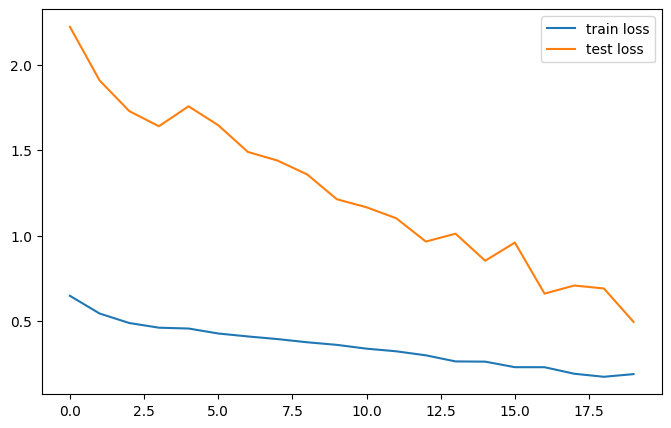

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(rnn_train_losses, label='train loss')
plt.plot(rnn_test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print('на train:')
cr_rnn_train = classification_report(train_labels, train_preds, target_names=label2idx.keys())
print(cr_rnn_train)

на train:
              precision    recall  f1-score   support

      собака       0.97      0.93      0.95       796
       кошка       0.95      0.98      0.96      1103

    accuracy                           0.96      1899
   macro avg       0.96      0.95      0.96      1899
weighted avg       0.96      0.96      0.96      1899



In [ ]:
test_preds = []
test_labels = []
with torch.no_grad():
  for batch in test_loader:
    inputs, labels = batch
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_preds.extend(preds.numpy())
    test_labels.extend(labels.numpy())

print('на test:')
cr_rnn_test = classification_report(test_labels, test_preds, target_names=label2idx.keys())
print(cr_rnn_test)

на test:
              precision    recall  f1-score   support

      собака       0.77      0.74      0.75       207
       кошка       0.81      0.82      0.82       268

    accuracy                           0.79       475
   macro avg       0.79      0.78      0.79       475
weighted avg       0.79      0.79      0.79       475



### 6.

<p class="task" id="6"></p>

6\. Решите предыщую задачу, заменив собственный модуль `RNN` на модули `nn.RNN`, `nn.LSTM` и `nn.GRU`. Сравните результаты работы.

- [ ] Проверено на семинаре

#### nn.RNN:

In [ ]:
class PetClassifier(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)
    self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x): # x - b x seq_len
    embed = self.embed(x) # b,seq_len,embed_dim
    output, h = self.rnn(embed) # output - b,seq_len, hidden_size
    last_out = output[:, -1, :] # b, hidden_size

    return self.fc(last_out)

In [ ]:
import torch.optim as optim

vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label2idx)

embed_dim = 32
hidden_size = 64

model = PetClassifier(vocab_size, embed_dim, hidden_size, num_classes)
crit = nn.CrossEntropyLoss()
optim = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
batch_size = 4

train_loader = DataLoader(train_datset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_datset, batch_size=batch_size)

In [ ]:
num_epochs = 20

nn_rnn_train_losses = []
nn_rnn_test_losses = []

for epoch in range(num_epochs):
  model.train()
  train_loss = 0

  for batch in train_loader:
    inputs, labels = batch
    optim.zero_grad()
    outputs = model(inputs)
    loss = crit(outputs, labels)
    loss.backward()
    optim.step()

    train_loss += loss.item()

  model.eval()
  test_loss = 0
  train_preds = []
  train_labels = []

  with torch.no_grad():
    for batch in train_loader:
      inputs, labels = batch

      outputs = model(inputs)
      _, preds = th.max(outputs, dim=1)
      loss = crit(outputs, labels)

      train_preds.extend(preds.numpy())
      train_labels.extend(labels.numpy())

      test_loss += loss.item()

  nn_rnn_train_losses.append(train_loss/len(train_loader))
  nn_rnn_test_losses.append(test_loss/len(test_loader))

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'train loss: {train_loss/len(train_loader):.4f} | test loss: {test_loss/len(test_loader):.4f}')

Epoch 1/20
train loss: 0.6598 | test loss: 2.2650
Epoch 2/20
train loss: 0.5701 | test loss: 2.0676
Epoch 3/20
train loss: 0.5283 | test loss: 1.8197
Epoch 4/20
train loss: 0.4644 | test loss: 1.7045
Epoch 5/20
train loss: 0.4605 | test loss: 1.6471
Epoch 6/20
train loss: 0.4528 | test loss: 1.8201
Epoch 7/20
train loss: 0.4195 | test loss: 1.4553
Epoch 8/20
train loss: 0.3978 | test loss: 1.4720
Epoch 9/20
train loss: 0.3868 | test loss: 1.4145
Epoch 10/20
train loss: 0.3605 | test loss: 1.2571
Epoch 11/20
train loss: 0.3460 | test loss: 1.2997
Epoch 12/20
train loss: 0.3236 | test loss: 1.1589
Epoch 13/20
train loss: 0.2982 | test loss: 1.0066
Epoch 14/20
train loss: 0.2850 | test loss: 0.9869
Epoch 15/20
train loss: 0.2731 | test loss: 0.8736
Epoch 16/20
train loss: 0.2456 | test loss: 0.7611
Epoch 17/20
train loss: 0.2240 | test loss: 0.9056
Epoch 18/20
train loss: 0.2057 | test loss: 0.9128
Epoch 19/20
train loss: 0.1969 | test loss: 0.6537
Epoch 20/20
train loss: 0.1730 | test lo

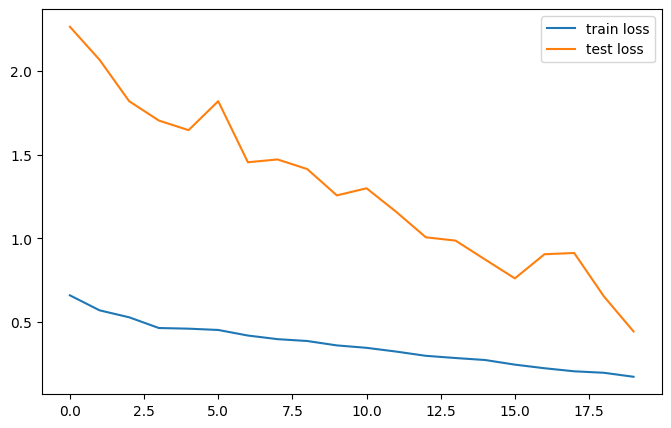

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(nn_rnn_train_losses, label='train loss')
plt.plot(nn_rnn_test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print('на train:')
cr_nn_rnn_train = classification_report(train_labels, train_preds, target_names=label2idx.keys())
print(cr_nn_rnn_train)

на train:
              precision    recall  f1-score   support

      собака       0.98      0.95      0.96       796
       кошка       0.97      0.98      0.97      1103

    accuracy                           0.97      1899
   macro avg       0.97      0.97      0.97      1899
weighted avg       0.97      0.97      0.97      1899



In [ ]:
test_preds = []
test_labels = []
with torch.no_grad():
  for batch in test_loader:
    inputs, labels = batch
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_preds.extend(preds.numpy())
    test_labels.extend(labels.numpy())

print('на test:')
cr_nn_rnn_test = classification_report(test_labels, test_preds, target_names=label2idx.keys())
print(cr_nn_rnn_test)

на test:
              precision    recall  f1-score   support

      собака       0.81      0.76      0.78       207
       кошка       0.82      0.86      0.84       268

    accuracy                           0.82       475
   macro avg       0.82      0.81      0.81       475
weighted avg       0.82      0.82      0.82       475



#### nn.LSTM:

In [ ]:
class PetClassifier(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)
    self.rnn = nn.LSTM(embed_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x): # x - b x seq_len
    embed = self.embed(x) # b,seq_len,embed_dim
    output, h = self.rnn(embed) # output - b,seq_len, hidden_size
    last_out = output[:, -1, :] # b, hidden_size

    return self.fc(last_out)

In [ ]:
import torch.optim as optim

vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label2idx)

embed_dim = 32
hidden_size = 64

model = PetClassifier(vocab_size, embed_dim, hidden_size, num_classes)
crit = nn.CrossEntropyLoss()
optim = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
batch_size = 4

train_loader = DataLoader(train_datset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_datset, batch_size=batch_size)

In [ ]:
num_epochs = 20

nn_lstm_train_losses = []
nn_lstm_test_losses = []

for epoch in range(num_epochs):
  model.train()
  train_loss = 0

  for batch in train_loader:
    inputs, labels = batch
    optim.zero_grad()
    outputs = model(inputs)
    loss = crit(outputs, labels)
    loss.backward()
    optim.step()

    train_loss += loss.item()

  model.eval()
  test_loss = 0
  train_preds = []
  train_labels = []

  with torch.no_grad():
    for batch in train_loader:
      inputs, labels = batch

      outputs = model(inputs)
      _, preds = th.max(outputs, dim=1)
      loss = crit(outputs, labels)

      train_preds.extend(preds.numpy())
      train_labels.extend(labels.numpy())

      test_loss += loss.item()

  nn_lstm_train_losses.append(train_loss/len(train_loader))
  nn_lstm_test_losses.append(test_loss/len(test_loader))

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'train loss: {train_loss/len(train_loader):.4f} | test loss: {test_loss/len(test_loader):.4f}')

Epoch 1/20
train loss: 0.5562 | test loss: 1.8154
Epoch 2/20
train loss: 0.4437 | test loss: 1.7747
Epoch 3/20
train loss: 0.4230 | test loss: 1.5983
Epoch 4/20
train loss: 0.4015 | test loss: 1.5154
Epoch 5/20
train loss: 0.3843 | test loss: 1.3888
Epoch 6/20
train loss: 0.3643 | test loss: 1.2891
Epoch 7/20
train loss: 0.3482 | test loss: 1.2354
Epoch 8/20
train loss: 0.3240 | test loss: 1.1815
Epoch 9/20
train loss: 0.3023 | test loss: 1.0721
Epoch 10/20
train loss: 0.2764 | test loss: 1.0926
Epoch 11/20
train loss: 0.2568 | test loss: 0.8079
Epoch 12/20
train loss: 0.2338 | test loss: 0.8542
Epoch 13/20
train loss: 0.2083 | test loss: 0.6683
Epoch 14/20
train loss: 0.1856 | test loss: 0.6050
Epoch 15/20
train loss: 0.1639 | test loss: 0.5442
Epoch 16/20
train loss: 0.1499 | test loss: 0.4372
Epoch 17/20
train loss: 0.1398 | test loss: 0.4111
Epoch 18/20
train loss: 0.1084 | test loss: 0.3114
Epoch 19/20
train loss: 0.1049 | test loss: 0.3068
Epoch 20/20
train loss: 0.0824 | test lo

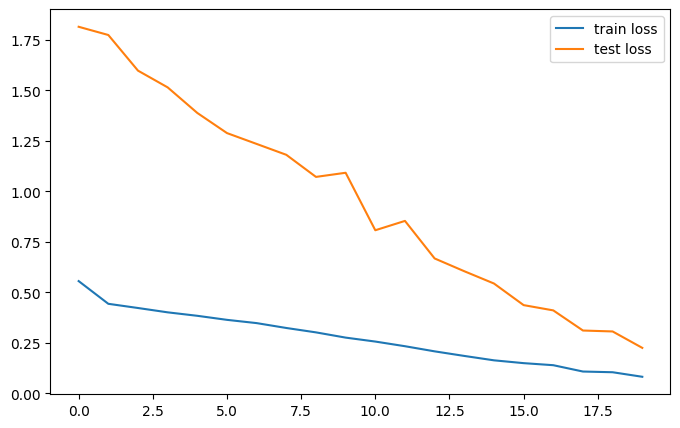

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(nn_lstm_train_losses, label='train loss')
plt.plot(nn_lstm_test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print('на train:')
cr_nn_lstm_train = classification_report(train_labels, train_preds, target_names=label2idx.keys())
print(cr_nn_lstm_train)

на train:
              precision    recall  f1-score   support

      собака       0.97      0.98      0.98       796
       кошка       0.98      0.98      0.98      1103

    accuracy                           0.98      1899
   macro avg       0.98      0.98      0.98      1899
weighted avg       0.98      0.98      0.98      1899



In [ ]:
test_preds = []
test_labels = []
with torch.no_grad():
  for batch in test_loader:
    inputs, labels = batch
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_preds.extend(preds.numpy())
    test_labels.extend(labels.numpy())

print('на test:')
cr_nn_lstm_test = classification_report(test_labels, test_preds, target_names=label2idx.keys())
print(cr_nn_lstm_test)

на test:
              precision    recall  f1-score   support

      собака       0.78      0.76      0.77       207
       кошка       0.82      0.83      0.82       268

    accuracy                           0.80       475
   macro avg       0.80      0.80      0.80       475
weighted avg       0.80      0.80      0.80       475



#### nn.GRU:

In [ ]:
class PetClassifier(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)
    self.rnn = nn.GRU(embed_dim, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x): # x - b x seq_len
    embed = self.embed(x) # b,seq_len,embed_dim
    output, h = self.rnn(embed) # output - b,seq_len, hidden_size
    last_out = output[:, -1, :] # b, hidden_size

    return self.fc(last_out)

In [ ]:
import torch.optim as optim

vocab_size = len(tokenizer.word_index) + 1
num_classes = len(label2idx)

embed_dim = 32
hidden_size = 64

model = PetClassifier(vocab_size, embed_dim, hidden_size, num_classes)
crit = nn.CrossEntropyLoss()
optim = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
batch_size = 4

train_loader = DataLoader(train_datset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_datset, batch_size=batch_size)

In [ ]:
num_epochs = 20

nn_gru_train_losses = []
nn_gru_test_losses = []

for epoch in range(num_epochs):
  model.train()
  train_loss = 0

  for batch in train_loader:
    inputs, labels = batch
    optim.zero_grad()
    outputs = model(inputs)
    loss = crit(outputs, labels)
    loss.backward()
    optim.step()

    train_loss += loss.item()

  model.eval()
  test_loss = 0
  train_preds = []
  train_labels = []

  with torch.no_grad():
    for batch in train_loader:
      inputs, labels = batch

      outputs = model(inputs)
      _, preds = th.max(outputs, dim=1)
      loss = crit(outputs, labels)

      train_preds.extend(preds.numpy())
      train_labels.extend(labels.numpy())

      test_loss += loss.item()

  nn_gru_train_losses.append(train_loss/len(train_loader))
  nn_gru_test_losses.append(test_loss/len(test_loader))

  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'train loss: {train_loss/len(train_loader):.4f} | test loss: {test_loss/len(test_loader):.4f}')

Epoch 1/20
train loss: 0.5307 | test loss: 1.7355
Epoch 2/20
train loss: 0.4350 | test loss: 1.6163
Epoch 3/20
train loss: 0.4122 | test loss: 1.5340
Epoch 4/20
train loss: 0.3966 | test loss: 1.4286
Epoch 5/20
train loss: 0.3732 | test loss: 1.3247
Epoch 6/20
train loss: 0.3543 | test loss: 1.2908
Epoch 7/20
train loss: 0.3309 | test loss: 1.2285
Epoch 8/20
train loss: 0.3138 | test loss: 1.0974
Epoch 9/20
train loss: 0.2864 | test loss: 0.9515
Epoch 10/20
train loss: 0.2591 | test loss: 0.8550
Epoch 11/20
train loss: 0.2316 | test loss: 0.7502
Epoch 12/20
train loss: 0.1963 | test loss: 0.5862
Epoch 13/20
train loss: 0.1698 | test loss: 0.4643
Epoch 14/20
train loss: 0.1407 | test loss: 0.3842
Epoch 15/20
train loss: 0.1063 | test loss: 0.3181
Epoch 16/20
train loss: 0.0990 | test loss: 0.2278
Epoch 17/20
train loss: 0.0895 | test loss: 0.2292
Epoch 18/20
train loss: 0.0644 | test loss: 0.1847
Epoch 19/20
train loss: 0.0501 | test loss: 0.1657
Epoch 20/20
train loss: 0.0499 | test lo

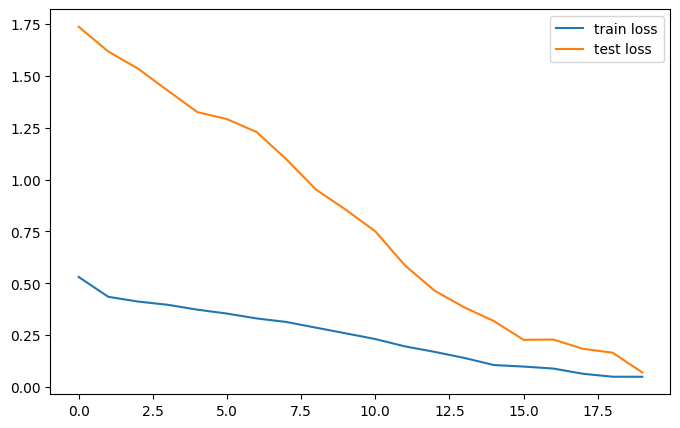

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(nn_gru_train_losses, label='train loss')
plt.plot(nn_gru_test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print('на train:')
cr_nn_gru_train = classification_report(train_labels, train_preds, target_names=label2idx.keys())
print(cr_nn_gru_train)

на train:
              precision    recall  f1-score   support

      собака       1.00      0.99      1.00       796
       кошка       1.00      1.00      1.00      1103

    accuracy                           1.00      1899
   macro avg       1.00      1.00      1.00      1899
weighted avg       1.00      1.00      1.00      1899



In [ ]:
test_preds = []
test_labels = []
with torch.no_grad():
  for batch in test_loader:
    inputs, labels = batch
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_preds.extend(preds.numpy())
    test_labels.extend(labels.numpy())

print('на test:')
cr_nn_gru_test = classification_report(test_labels, test_preds, target_names=label2idx.keys())
print(cr_nn_gru_test)

на test:
              precision    recall  f1-score   support

      собака       0.77      0.78      0.78       207
       кошка       0.83      0.82      0.82       268

    accuracy                           0.80       475
   macro avg       0.80      0.80      0.80       475
weighted avg       0.80      0.80      0.80       475



#### Итог:

In [ ]:
print('RNN train:')
print(cr_rnn_train)
print('\nRNN test:')
print(cr_rnn_test)

RNN train:
              precision    recall  f1-score   support

      собака       0.97      0.93      0.95       796
       кошка       0.95      0.98      0.96      1103

    accuracy                           0.96      1899
   macro avg       0.96      0.95      0.96      1899
weighted avg       0.96      0.96      0.96      1899


RNN test:
              precision    recall  f1-score   support

      собака       0.77      0.74      0.75       207
       кошка       0.81      0.82      0.82       268

    accuracy                           0.79       475
   macro avg       0.79      0.78      0.79       475
weighted avg       0.79      0.79      0.79       475



In [ ]:
print('nn.RNN train:')
print(cr_nn_rnn_train)
print('\nnn.RNN test:')
print(cr_nn_rnn_test)

nn.RNN train:
              precision    recall  f1-score   support

      собака       0.98      0.95      0.96       796
       кошка       0.97      0.98      0.97      1103

    accuracy                           0.97      1899
   macro avg       0.97      0.97      0.97      1899
weighted avg       0.97      0.97      0.97      1899


nn.RNN test:
              precision    recall  f1-score   support

      собака       0.81      0.76      0.78       207
       кошка       0.82      0.86      0.84       268

    accuracy                           0.82       475
   macro avg       0.82      0.81      0.81       475
weighted avg       0.82      0.82      0.82       475



In [ ]:
print('nn.LSTM train:')
print(cr_nn_lstm_train)
print('\nnn.LSTM test:')
print(cr_nn_lstm_test)

nn.LSTM train:
              precision    recall  f1-score   support

      собака       0.97      0.98      0.98       796
       кошка       0.98      0.98      0.98      1103

    accuracy                           0.98      1899
   macro avg       0.98      0.98      0.98      1899
weighted avg       0.98      0.98      0.98      1899


nn.LSTM test:
              precision    recall  f1-score   support

      собака       0.78      0.76      0.77       207
       кошка       0.82      0.83      0.82       268

    accuracy                           0.80       475
   macro avg       0.80      0.80      0.80       475
weighted avg       0.80      0.80      0.80       475



In [ ]:
print('nn.GRU train:')
print(cr_nn_gru_train)
print('\nnn.GRU test:')
print(cr_nn_gru_test)

nn.GRU train:
              precision    recall  f1-score   support

      собака       1.00      0.99      1.00       796
       кошка       1.00      1.00      1.00      1103

    accuracy                           1.00      1899
   macro avg       1.00      1.00      1.00      1899
weighted avg       1.00      1.00      1.00      1899


nn.GRU test:
              precision    recall  f1-score   support

      собака       0.77      0.78      0.78       207
       кошка       0.83      0.82      0.82       268

    accuracy                           0.80       475
   macro avg       0.80      0.80      0.80       475
weighted avg       0.80      0.80      0.80       475



accuracy на тестовых данных:

RNN: 79%
nn.RNN: 82%
nn.LSTM: 80%
nn.GRU: 80%

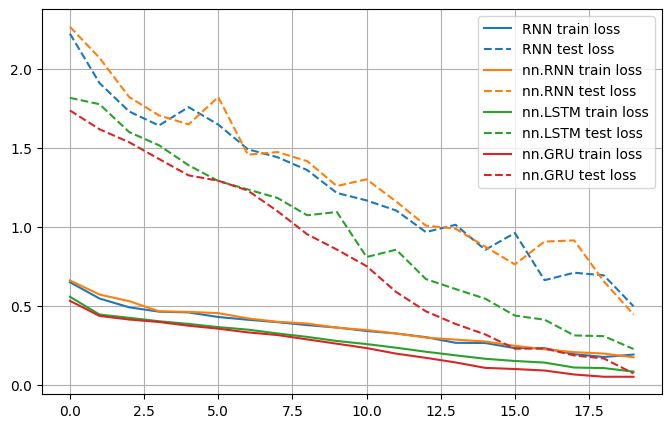

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))


plt.plot(rnn_train_losses, c='C0', label='RNN train loss')
plt.plot(rnn_test_losses, c='C0', linestyle='--', label='RNN test loss')
plt.plot(nn_rnn_train_losses,  c='C1', label='nn.RNN train loss')
plt.plot(nn_rnn_test_losses, c='C1', linestyle='--',label='nn.RNN test loss')

plt.plot(nn_lstm_train_losses, c='C2', label='nn.LSTM train loss')
plt.plot(nn_lstm_test_losses, c='C2', linestyle='--',label='nn.LSTM test loss')
plt.plot(nn_gru_train_losses, c='C3',label='nn.GRU train loss')
plt.plot(nn_gru_test_losses, c='C3', linestyle='--', label='nn.GRU test loss')
plt.grid()
plt.legend()
plt.show()

Сравнение результатов:

по графику моя модель с RNN и модель с nn.RNN обучают примерно одинаково, тоже самое с моделями с nn.LSTM и nn.GRU

по accuracy лучшей моделью является модель с nn.RNN

по итогам обучения, nn.GRU справляется лучше всех, по графику имеет наименьшие ошибки